In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import skimage
from sklearn.cluster import KMeans
# python library to read tiff images
import tiffile as tiff
from tqdm import tqdm

# makes inline plots to have better quality
# %config InlineBackend.figure_format = 'svg'

## 1. Extract the metadata information

a) What is the size (pixels - x and y) of the image?

b) How many markers/channels does the image has?


In [2]:
# Read the image
img_raw = tiff.imread("images/Example.tif")

In [3]:
img_raw.shape

(40, 1001, 1001)

In [4]:
img_raw.dtype

dtype('uint16')

In [5]:
# Convert image to uint8 dtype (values from 0 to 255)
img = (img_raw / 256).astype(np.uint8)

In [6]:
img.dtype

dtype('uint8')

The image has shape of (40 x 1001 x 1001)

**a) The size of the image is 1001 x 1001 (x=1001, y=1001)**

**b) The image has 40 channels**

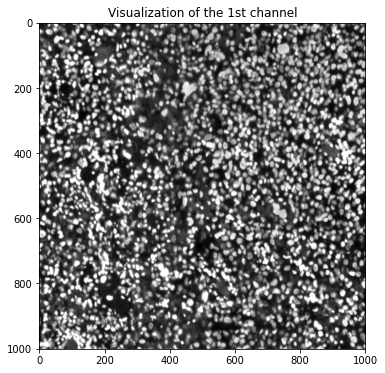

In [7]:
plt.figure(figsize=(6,6))
plt.imshow(img[0],  cmap='gray')
plt.title("Visualization of the 1st channel")
plt.show()

## 2. Download the CSV with the description of the individual markers/channels

a) Visualize Hoechst3, S100 and Vimentin as an RGB image.

b) Compare the intensities across all Hoechst channels (Hoechst1 to Hoechst10 - including all 10 channels). Describe any variation in signal across the 10 Hoechst channels in statistical terms.


In [8]:
markers_df = pd.read_csv("Triplet_40_markers.csv", header=None, names=["marker_name"])

In [9]:
markers_df.shape

(40, 1)

In [10]:
# Look at the markers' names
markers_df.head(40)

,marker_name
0,Hoechst1
1,A488
2,A555
3,A647
4,Hoechst2
5,pERK
6,AXL
7,MITF
8,Hoechst3
9,S100


**a) Visualize Hoechst3, S100 and Vimentin as an RGB image**

In [11]:
marker_to_viz = ["Hoechst3", "S100", "VIMENTIN"]
marker_ids = markers_df[markers_df["marker_name"].isin(marker_to_viz)].index.to_list()
print(marker_ids)

[8, 9, 14]


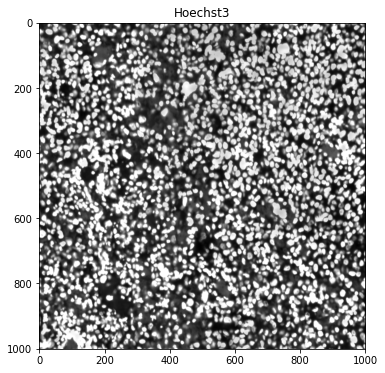

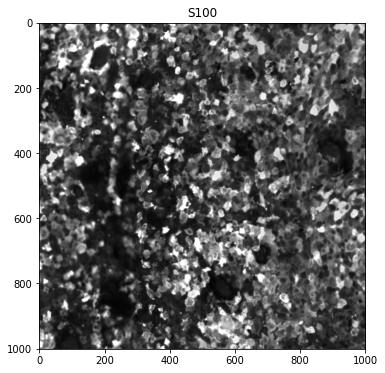

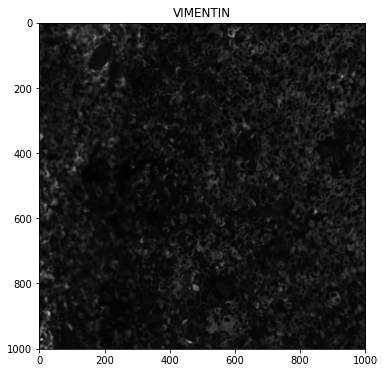

In [12]:
# Visualize Hoechst3, S100 and Vimentin as grayscale images (1-channel images)
for (idx, mk_name) in zip(marker_ids, marker_to_viz):
    plt.figure(figsize=(6,6))
    plt.imshow(img[idx],  cmap='gray')
    plt.title(mk_name)
    plt.show()


In [13]:
# Combine images from the three channels
stacked_img = np.stack(img[marker_ids], axis=-1)

In [14]:
stacked_img.shape

(1001, 1001, 3)

In [15]:
stacked_img.dtype

dtype('uint8')

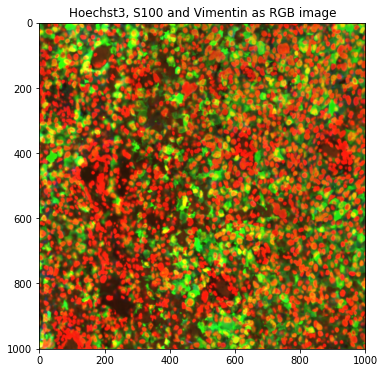

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(stacked_img)
plt.title("Hoechst3, S100 and Vimentin as RGB image")
plt.show()

**b) Compare the intensities across all Hoechst channels (Hoechst1 to Hoechst10 - including all 10 channels). Describe any variation in signal across the 10 Hoechst channels in statistical terms**

In [17]:
hoechst_markers = ["Hoechst{}".format(i) for i in range(1, 11)]
hoechst_markers

['Hoechst1',
 'Hoechst2',
 'Hoechst3',
 'Hoechst4',
 'Hoechst5',
 'Hoechst6',
 'Hoechst7',
 'Hoechst8',
 'Hoechst9',
 'Hoechst10']

In [18]:
hoechst_marker_ids = markers_df[markers_df["marker_name"].isin(hoechst_markers)].index.to_list()
hoechst_marker_ids 

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36]

In [19]:
mean_intensities = []
intensity_stds = []
for idx in hoechst_marker_ids:
    mean_intensities.append(np.mean(img[idx]).astype(int))
    intensity_stds.append(np.std(img[idx]).astype(int))

In [20]:
mean_intensities

[112, 119, 134, 141, 148, 114, 55, 109, 125, 103]

In [21]:
intensity_stds

[64, 64, 73, 75, 74, 68, 37, 67, 65, 54]

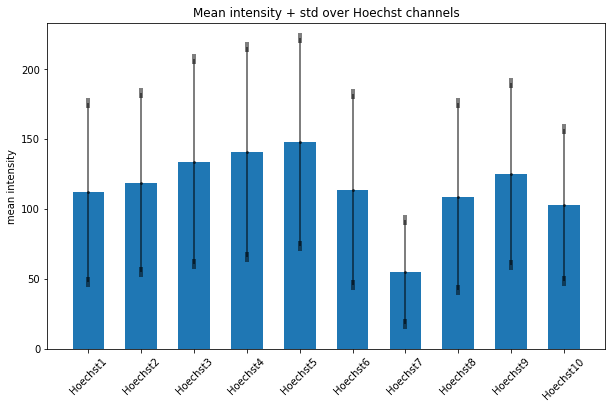

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(hoechst_markers, mean_intensities, width=0.6)
plt.errorbar(
    hoechst_markers, mean_intensities, yerr=intensity_stds, 
    fmt='.', color='Black', elinewidth=2, capthick=10,
    errorevery=1, alpha=0.5, ms=4, capsize=2
)
plt.xticks(rotation=45)
plt.ylabel("mean intensity")
plt.title("Mean intensity + std over Hoechst channels")
plt.show()

In [23]:
# Compute correlation between image vectors
corr_matrix = np.corrcoef([img[i].flatten() for i in hoechst_marker_ids])

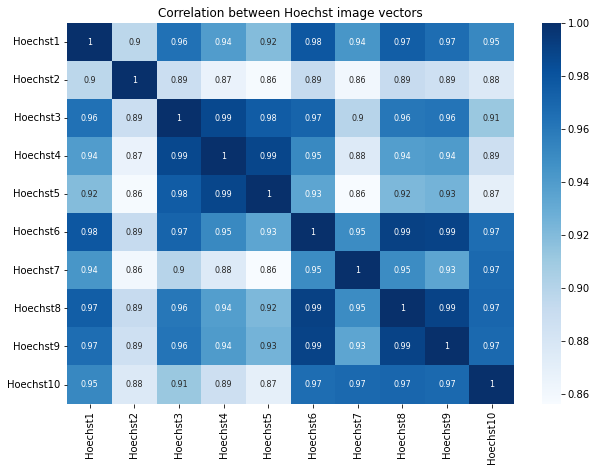

In [24]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix, 
    xticklabels=hoechst_markers, 
    yticklabels=hoechst_markers, 
    annot=True,
    annot_kws={"size": 8},
    cmap='Blues'
)
plt.title("Correlation between Hoechst image vectors")
plt.show()

## 3. Binary mask

a) Extract all mean intensities from each object by combining the mask and the multipage tiff

b) Optional: How could we cluster the objects according to their marker intensity? Provide one or multiple examples

c) Optional: How could we cluster the objects according to their neighborhood? Provide one or multiple examples

d) Optional: Visualize the clusters from b and c directly on the image

In [25]:
mask = cv2.imread("images/Mask.tif", cv2.IMREAD_GRAYSCALE)

In [26]:
mask.shape

(1001, 1001)

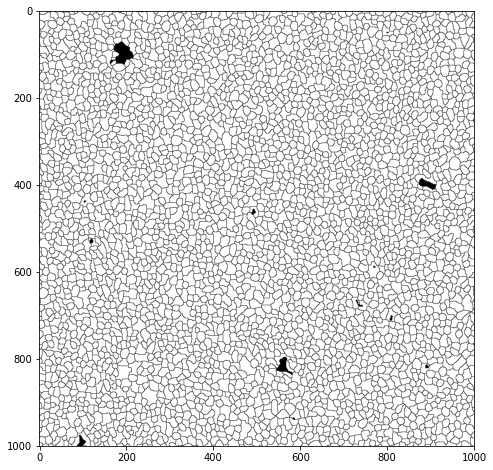

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap="gray")
plt.show()

In [28]:
def calculate_intensity_matrix(img, mask, markers_df):
    # Find connected components (objects)
    num_labels, img_labels = cv2.connectedComponents(mask)
    
    num_markers = markers_df.shape[0]
    intensity_matrix = np.zeros((num_labels-1, num_markers))
    
    for label in tqdm(range(1, num_labels)):
        # Extract object mask
        object_mask = np.where(img_labels == label, 1, 0).astype("uint8")
        # Mask multichannel image
        masked_img = img & object_mask
        # Find coordinates of non-zero pixels for the object
        nonzero_idx = np.nonzero(masked_img[0])
        for marker_id in range(num_markers):
            mean_obj_intensity = np.mean(img[marker_id][nonzero_idx]).astype(int)
            intensity_matrix[label-1, marker_id] = mean_obj_intensity   
    return intensity_matrix
    

In [29]:
intensity_matrix = calculate_intensity_matrix(img, mask, markers_df)

  2%|▋                                       | 71/3933 [00:00<00:32, 117.82it/s]/Users/ashalygina/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ashalygina/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████| 3933/3933 [00:33<00:00, 118.86it/s]


In [30]:
intensity_matrix.shape

(3933, 40)

In [31]:
marker_names = markers_df["marker_name"].to_list()
df_columns = ["ObjectID"] + marker_names
intensity_df = pd.DataFrame(columns=df_columns)
intensity_df

,ObjectID,Hoechst1,A488,A555,A647,Hoechst2,pERK,AXL,MITF,Hoechst3,...,pRB,NGFR,Hoechst9,MITF_9,KERATIN,HES1,Hoechst10,pS6,CD45,pERKz


In [32]:
intensity_df["ObjectID"] = np.arange(1, intensity_matrix.shape[0]+1)
intensity_df[marker_names] = intensity_matrix.astype(int)

In [33]:
intensity_df

,ObjectID,Hoechst1,A488,A555,A647,Hoechst2,pERK,AXL,MITF,Hoechst3,...,pRB,NGFR,Hoechst9,MITF_9,KERATIN,HES1,Hoechst10,pS6,CD45,pERKz
0,1,47,42,17,8,59,42,26,20,53,...,5,23,58,25,6,72,54,56,5,6
1,2,107,42,18,9,117,45,28,45,134,...,5,31,107,30,6,50,93,70,5,6
2,3,121,60,24,10,124,53,40,19,139,...,5,7,131,28,7,40,110,48,6,7
3,4,215,56,24,10,187,84,39,19,229,...,6,5,179,28,7,54,152,42,8,7
4,5,75,75,32,11,92,108,55,24,84,...,6,5,118,31,7,57,92,38,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,3929,104,31,12,9,113,35,22,35,136,...,4,8,103,27,4,78,76,28,3,8
3929,3930,69,35,14,11,80,52,27,18,82,...,5,5,67,22,5,127,54,106,5,8
3930,3931,67,33,13,13,86,36,28,36,77,...,5,5,64,26,4,55,53,42,3,10
3931,3932,112,46,19,9,101,49,31,41,139,...,6,4,109,29,6,52,81,28,3,6


In [34]:
# Save dataframe
intensity_df.to_csv("mean_intensities.csv", index=False)

### Optional part

**b) Optional: How could we cluster the objects according to their marker intensity? Provide one or multiple examples**

We could use the intensities from the table above as features for clustering, and apply any clustering algorithm. For example, KMeans or DBSCAN.
I am going to apply KMeans as an example.

In [35]:
clustering = KMeans(n_clusters=20)
clustering.fit(intensity_df[marker_names])

KMeans(n_clusters=20)

In [36]:
def get_clustered_image(mask, object_ids, img_comp, cluster_labels):
    """
    Color objects in the mask according to cluster labels
    """
    labeled_img = np.zeros(mask.shape)
    for label in np.unique(cluster_labels):
        objects_cluster = object_ids[cluster_labels==label]
        colour_marker = label+1
        cluster_mask = np.where(np.isin(img_comp, objects_cluster), colour_marker, 0).astype("uint8")
        labeled_img += cluster_mask
    colored_cluster_image = skimage.color.label2rgb(labeled_img, bg_label=0)
    return colored_cluster_image

In [37]:
labels = clustering.labels_

# Get image components
num_components, img_components = cv2.connectedComponents(mask)

object_ids = intensity_df["ObjectID"].values

In [38]:
result_img = get_clustered_image(mask, object_ids, img_components, labels)

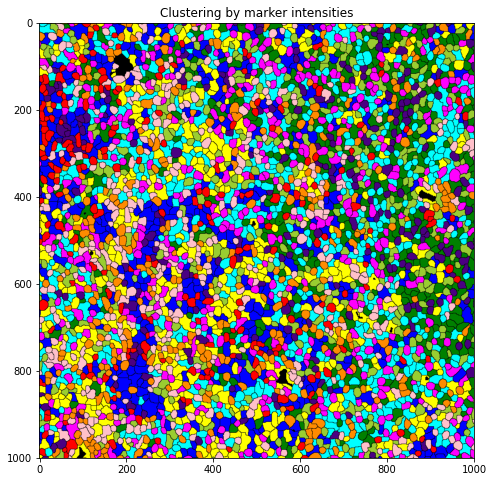

In [39]:
plt.figure(figsize=(8,8))
plt.imshow(result_img)
plt.title("Clustering by marker intensities")
plt.show()

**c) Optional: How could we cluster the objects according to their neighborhood? Provide one or multiple examples**

We could cluster the objects by Euclidean distances between coordinates of the object centers

In [40]:
# Find centroids of the objects
_, _, _, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

In [41]:
centroids.shape

(3934, 2)

In [42]:
centroids

array([[4.97469845e+02, 4.95709374e+02],
       [8.25619835e+00, 2.93388430e+00],
       [2.27692308e+01, 4.61538462e-01],
       ...,
       [9.93800000e+02, 9.99600000e+02],
       [3.23500000e+02, 1.00000000e+03],
       [7.61500000e+02, 1.00000000e+03]])

In [43]:
object_centroids = centroids[object_ids]

In [44]:
clustering = KMeans(n_clusters=20)
clustering.fit(object_centroids)

KMeans(n_clusters=20)

In [45]:
labels = clustering.labels_

In [46]:
result_img = get_clustered_image(mask, object_ids, img_components, labels)

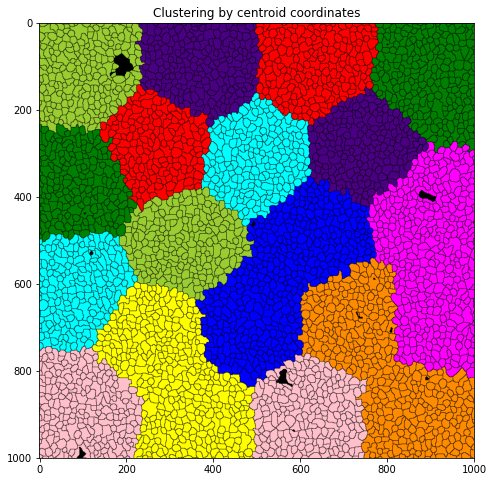

In [47]:
plt.figure(figsize=(8,8))
plt.imshow(result_img)
plt.title("Clustering by centroid coordinates")
plt.show()